In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers

# data visualization
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Imported modules.")

Imported modules.


#### ***Load Datasets***

In [2]:
# load train data
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
# Shuffle train data...
train_df = train_df.reindex(np.random.permutation(train_df.index))

# Load test data
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

In [3]:
# Normalize Data
# train data normalization
train_mean = train_df.mean()
train_std = train_df.std()

normalized_train_df = (train_df - train_mean)/train_std

# test data normalization
test_mean = test_df.mean()
test_std = test_df.std()

normalized_test_df = (test_df - test_mean) / test_std

print("Normalization is done!")

Normalization is done!


In [4]:
normalized_train_df.head(7)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
1609,1.2,-0.9,-0.4,0.4,0.4,1.1,0.3,-1.0,-1.1
16673,-1.6,1.3,1.1,-0.6,-0.6,-0.4,-0.5,-0.7,-0.5
4598,0.7,-0.8,1.3,-0.5,-0.7,-0.7,-0.7,0.3,-0.2
6050,0.7,-0.8,0.3,-0.2,0.2,0.8,0.3,-0.7,-0.3
1116,1.2,-1.0,-2.0,12.7,10.5,10.3,10.0,0.4,0.0
1935,1.1,-1.2,0.1,0.0,0.0,-0.1,0.0,0.4,0.7
735,1.3,-1.4,-0.3,-0.2,-0.4,0.1,-0.3,0.7,-0.6


In [5]:
normalized_test_df.head(7)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-1.2,0.8,-0.1,0.6,0.3,0.1,0.3,1.5,1.2
1,0.6,-0.6,1.1,-0.5,-0.5,-0.6,-0.6,-0.1,-0.3
2,0.9,-0.9,-0.1,0.5,-0.1,0.1,0.0,1.1,0.6
3,0.6,-0.9,-0.1,-1.2,-1.2,-1.3,-1.3,1.3,1.1
4,-0.0,0.3,-0.8,-0.6,-0.7,-0.5,-0.7,-0.5,-1.1
5,0.0,0.4,0.6,-0.7,-0.8,-0.7,-0.8,-1.2,-1.2
6,-0.9,1.4,1.1,-0.7,-0.7,-0.8,-0.7,-1.2,-1.2


#### ***Representing Data*** 

- **latitude** $\times$ **longitude** (*feature cross)
- **median income**
- **population**

We'll be creating these features in the following code cell.

In [6]:
# Create an empty list that will eventually hold all created feature columns.
feature_columns = []

# We scaled all the columns, including latitude and longitude, into their
# Z scores. So, instead of picking a resolution in degrees, we're going
# to use resolution_in_Zs.  A resolution_in_Zs of 1 corresponds to 
# a full standard deviation. 
resolution_in_Zs = 0.3  # 3/10 of a standard deviation

# Create a bucket feature column for latitude.
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(normalized_train_df['latitude'])), 
                                     int(max(normalized_train_df['latitude'])), 
                                     resolution_in_Zs))

latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)

# Create a bucket feature column for longitude.
longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(normalized_train_df['longitude'])), 
                                      int(max(normalized_train_df['longitude'])), 
                                      resolution_in_Zs))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, 
                                                longitude_boundaries)


# Create a feature cross of latitude and longitude.
latitude_x_longitude = tf.feature_column.crossed_column([latitude, longitude], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(latitude_x_longitude)
feature_columns.append(crossed_feature)  

# Represent median_income as a floating-point value.
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

# Represent population as a floating-point value.
population = tf.feature_column.numeric_column("population")
feature_columns.append(population)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

#### ***Baseline model: Build Linear Regression Model*** 

###### *Define Helper Functions*

In [7]:
# Define plotting function
def plot_the_loss_curve(epochs, mse):
    plt.figure()
    # Heading Axis of the plot
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")

    plt.plot(epochs, mse, label="Loss")
    plt.legend()
    # Setting the upper and lower limit of the y-axis
    plt.ylim([mse.min()*0.95, mse.max() * 1.03])
    
    plt.show()  

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


In [8]:
# Define the functions that create and train the Linear Regression Model.
def create_model(learning_rate, feature_layer):
    # most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()
    
    # add feature_layer to the model.
    model.add(feature_layer)
    
    # add linear layer to the model to yield a simple linear regressor.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))
    
    # Construct the layers into a model
    # So that tf can execute.
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=learning_rate),
                 loss="mean_squared_error",
                 metrics=[tf.keras.metrics.MeanSquaredError()])
    
    return model

# define training function
def train_model(model, dataset, epochs, batch_size, label_name):
    
    # Split data into feature and target/label
    features = {name:np.array(value) for name, value in dataset.items()}
    target = np.array(features.pop(label_name))
    
    # Fit model.
    history = model.fit(x=features, y=target, 
                        batch_size = batch_size, 
                        epochs = epochs,
                        shuffle= True)
    # Get Details
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    mse = hist["mean_squared_error"]
    
    return epochs, mse

print("Defined the create & train model functions.")

Defined the create & train model functions.


In [9]:
# Define evaluation function
def evaluate(df, label_name, feature_layer, learning_rate=.01, epochs=10, batch_size=100):
    # create model
    model = create_model(learning_rate = learning_rate, 
                         feature_layer = feature_layer)
    # train the model
    epochs, mse = train_model(model=model, dataset=df,
                               epochs=epochs, 
                               batch_size=batch_size,
                               label_name= label_name)
    # plot the loss curve
    plot_the_loss_curve(epochs, mse)
    
    return model

print("Defined the create & train evaluation function.")

Defined the create & train evaluation function.


Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Train on 17000 samples
Epoch 1/15
17000/17000 [==============================] - 1s 30us/sample - loss: 0.5826 - mean_squared_error: 0.5826
Epoch 2/15
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4335 - mean_squared_error: 0.4335
Epoch 3/15
17000/17000 [==============================] - 0s 2us/sample - loss: 0.3870 - mean_squared_error: 0.3870
Epoch 4/15
17000/17000 [==============================] - 0s 2us/sample - loss: 0.3714 - mean_squared_error: 0.3714
Epoch 5/15
17000/17000 [==============================] - 0s 2us/sample - loss: 0.3648 - mean_squared_error: 0.3648
Epoch 6/15
17000/17000 [==============================] - 0s 2us/sample - loss: 0.3618 - mean_squared_error: 0.3618
Epoch 7/15
17000/17000 [========

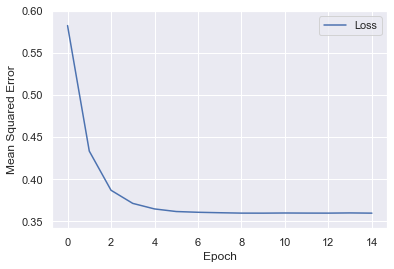


Evaluating the Linear Regression Model against the test set:

3000/3000 [==============================] - 0s 45us/sample - loss: 0.3950 - mean_squared_error: 0.3950


[0.39497969547907513, 0.3949797]

In [10]:
model = evaluate(df = normalized_train_df, 
                 label_name = "median_house_value", 
                 feature_layer = my_feature_layer, 
                 learning_rate=.01, 
                 epochs=15, 
                 batch_size=1000)

# Split data into feature and target/label
test_features = {name:np.array(value) for name, value in normalized_test_df.items()}
test_target = np.array(test_features.pop("median_house_value")) # label isolation

print("\nEvaluating the Linear Regression Model against the test set:\n")
model.evaluate(x=test_features, y=test_target, batch_size = 1000)

In [11]:
# model creation function with hidden layers
def create_model_w_hidden_layers(learning_rate, feature_layer):
    # most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()
    
    # add feature_layer to the model.
    model.add(feature_layer)
    
    # Add the first hidden layer with 20 nodes
    model.add(tf.keras.layers.Dense(units=10,
                                    activation="relu",
                                    kernel_regularizer = tf.keras.regularizers.l1(0.003),
                                    name="HiddenLayer1"))
    
    # Add the second hidden layer with 12 nodes.
    model.add(tf.keras.layers.Dense(units=6,
                                    activation="relu",
                                    kernel_regularizer = tf.keras.regularizers.l1(0.003),
                                    name="HiddenLayer2"))
    
    
    # add output layer.
    model.add(tf.keras.layers.Dense(units=1,
                                    name="Output"))
    
    # Construct the layers into a model
    # So that tf can execute.
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                 loss="mean_squared_error",
                 metrics=[tf.keras.metrics.MeanSquaredError()])
    
    return model

# Define evaluation function
def evaluate_w_hidden_layers(df, label_name, feature_layer, learning_rate=.01, epochs=10, batch_size=100):
    # create model
    model = create_model_w_hidden_layers(learning_rate = learning_rate, 
                                         feature_layer = feature_layer)
    # train the model
    epochs, mse = train_model(model=model, dataset=df,
                               epochs=epochs, 
                               batch_size=batch_size,
                               label_name= label_name)
    # plot the loss curve
    plot_the_loss_curve(epochs, mse)
    
    return model

print("Defined the create & train with hidden layers evaluation function.")

Defined the create & train with hidden layers evaluation function.


Train on 17000 samples
Epoch 1/20
17000/17000 [==============================] - 1s 30us/sample - loss: 0.9151 - mean_squared_error: 0.6614
Epoch 2/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.5177 - mean_squared_error: 0.3896
Epoch 3/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4617 - mean_squared_error: 0.3596
Epoch 4/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4379 - mean_squared_error: 0.3557
Epoch 5/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4254 - mean_squared_error: 0.3522
Epoch 6/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4188 - mean_squared_error: 0.3514
Epoch 7/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4112 - mean_squared_error: 0.3484
Epoch 8/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4070 - mean_squared_error: 0.3480
Epoch 9/20
17000/17000 [========================

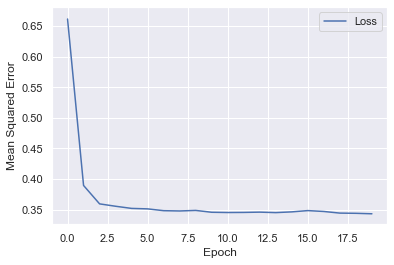


Evaluating the Deep NN Model against the test set:

3000/3000 [==============================] - 0s 53us/sample - loss: 0.4171 - mean_squared_error: 0.3770


[0.4171006381511688, 0.37698162]

In [12]:
model = evaluate_w_hidden_layers(df = normalized_train_df, 
                                 label_name = "median_house_value", 
                                 feature_layer = my_feature_layer, 
                                 learning_rate=.01, 
                                 epochs=20, batch_size=1000)

# Split data into feature and target/label
test_features = {name:np.array(value) for name, value in normalized_test_df.items()}
test_target = np.array(test_features.pop("median_house_value")) # label isolation

print("\nEvaluating the Deep NN Model against the test set:\n")
model.evaluate(x=test_features, y=test_target, batch_size = 1000)

##### Comparing two models:
Since loss of the deep nn model is lower than the baseline linear regression model, the deep nn model will make better predictions than the linear regression model.

#### Optimizing Deep NN 

Train on 17000 samples
Epoch 1/20
17000/17000 [==============================] - 1s 36us/sample - loss: 1.0580 - mean_squared_error: 0.8043
Epoch 2/20
17000/17000 [==============================] - 0s 3us/sample - loss: 0.5543 - mean_squared_error: 0.4257
Epoch 3/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4765 - mean_squared_error: 0.3694
Epoch 4/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4506 - mean_squared_error: 0.3607
Epoch 5/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4386 - mean_squared_error: 0.3590
Epoch 6/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4305 - mean_squared_error: 0.3572
Epoch 7/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4240 - mean_squared_error: 0.3560
Epoch 8/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4190 - mean_squared_error: 0.3551
Epoch 9/20
17000/17000 [========================

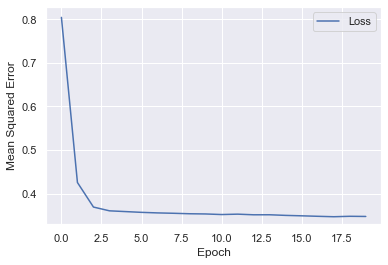


Evaluating the Deep NN Model against the test set:

3000/3000 [==============================] - 0s 54us/sample - loss: 0.4210 - mean_squared_error: 0.3802


[0.4209572474161784, 0.3801884]

In [13]:
# One Layer Results...
model = evaluate_w_hidden_layers(df = normalized_train_df, 
                                 label_name = "median_house_value", 
                                 feature_layer = my_feature_layer, 
                                 learning_rate=.01, 
                                 epochs=20, batch_size=1000)

# Split data into feature and target/label
test_features = {name:np.array(value) for name, value in normalized_test_df.items()}
test_target = np.array(test_features.pop("median_house_value")) # label isolation

print("\nEvaluating the Deep NN Model against the test set:\n")
model.evaluate(x=test_features, y=test_target, batch_size = 1000)

Train on 17000 samples
Epoch 1/20
17000/17000 [==============================] - 1s 31us/sample - loss: 1.0871 - mean_squared_error: 0.8462
Epoch 2/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.5787 - mean_squared_error: 0.4683
Epoch 3/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4704 - mean_squared_error: 0.3772
Epoch 4/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4385 - mean_squared_error: 0.3604
Epoch 5/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4223 - mean_squared_error: 0.3546
Epoch 6/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4142 - mean_squared_error: 0.3527
Epoch 7/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4086 - mean_squared_error: 0.3511
Epoch 8/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4077 - mean_squared_error: 0.3525
Epoch 9/20
17000/17000 [========================

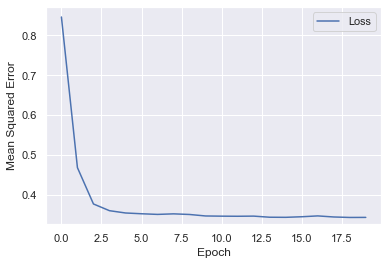


Evaluating the Deep NN Model against the test set:

3000/3000 [==============================] - 0s 53us/sample - loss: 0.4194 - mean_squared_error: 0.3775


[0.4194350739320119, 0.37749022]

In [14]:
# 3 Layer Results
model = evaluate_w_hidden_layers(df = normalized_train_df, 
                                 label_name = "median_house_value", 
                                 feature_layer = my_feature_layer, 
                                 learning_rate=.01, 
                                 epochs=20, batch_size=1000)

# Split data into feature and target/label
test_features = {name:np.array(value) for name, value in normalized_test_df.items()}
test_target = np.array(test_features.pop("median_house_value")) # label isolation

print("\nEvaluating the Deep NN Model against the test set:\n")
model.evaluate(x=test_features, y=test_target, batch_size = 1000)

***
* 2 layers outperform the a layer and 3 layers, it seems 2 layers best option.

***Changing the units***

Train on 17000 samples
Epoch 1/20
17000/17000 [==============================] - 1s 38us/sample - loss: 1.1667 - mean_squared_error: 0.9150
Epoch 2/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.5922 - mean_squared_error: 0.4655
Epoch 3/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4910 - mean_squared_error: 0.3832
Epoch 4/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4551 - mean_squared_error: 0.3640
Epoch 5/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4379 - mean_squared_error: 0.3578
Epoch 6/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4271 - mean_squared_error: 0.3541
Epoch 7/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4201 - mean_squared_error: 0.3526
Epoch 8/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4156 - mean_squared_error: 0.3516
Epoch 9/20
17000/17000 [========================

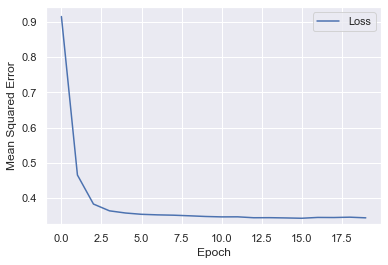


Evaluating the Deep NN Model against the test set:

3000/3000 [==============================] - 0s 54us/sample - loss: 0.4173 - mean_squared_error: 0.3776


[0.41728390256563824, 0.37760848]

In [15]:
# 1. Layer Units: 15, 2. Layers Units: 7
model = evaluate_w_hidden_layers(df = normalized_train_df, 
                                 label_name = "median_house_value", 
                                 feature_layer = my_feature_layer, 
                                 learning_rate=.01, 
                                 epochs=20, batch_size=1000)

# Split data into feature and target/label
test_features = {name:np.array(value) for name, value in normalized_test_df.items()}
test_target = np.array(test_features.pop("median_house_value")) # label isolation

print("\nEvaluating the Deep NN Model against the test set:\n")
model.evaluate(x=test_features, y=test_target, batch_size = 1000)

Train on 17000 samples
Epoch 1/20
17000/17000 [==============================] - 1s 30us/sample - loss: 1.1392 - mean_squared_error: 0.8951
Epoch 2/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.7688 - mean_squared_error: 0.6583
Epoch 3/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.6489 - mean_squared_error: 0.5694
Epoch 4/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.5747 - mean_squared_error: 0.5118
Epoch 5/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.5285 - mean_squared_error: 0.4730
Epoch 6/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4955 - mean_squared_error: 0.4454
Epoch 7/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4720 - mean_squared_error: 0.4257
Epoch 8/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4535 - mean_squared_error: 0.4099
Epoch 9/20
17000/17000 [========================

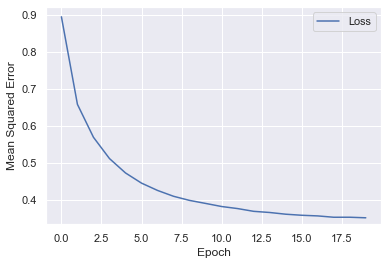


Evaluating the Deep NN Model against the test set:

3000/3000 [==============================] - 0s 54us/sample - loss: 0.4191 - mean_squared_error: 0.3865


[0.41914962728818256, 0.38654158]

In [16]:
# 1. Layer Units: 10, 2. Layers Units: 12
model = evaluate_w_hidden_layers(df = normalized_train_df, 
                                 label_name = "median_house_value", 
                                 feature_layer = my_feature_layer, 
                                 learning_rate=.01, 
                                 epochs=20, batch_size=1000)

# Split data into feature and target/label
test_features = {name:np.array(value) for name, value in normalized_test_df.items()}
test_target = np.array(test_features.pop("median_house_value")) # label isolation

print("\nEvaluating the Deep NN Model against the test set:\n")
model.evaluate(x=test_features, y=test_target, batch_size = 1000)

Train on 17000 samples
Epoch 1/20
17000/17000 [==============================] - 1s 38us/sample - loss: 0.9943 - mean_squared_error: 0.7580
Epoch 2/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.5483 - mean_squared_error: 0.4429
Epoch 3/20
17000/17000 [==============================] - 0s 3us/sample - loss: 0.4646 - mean_squared_error: 0.3789
Epoch 4/20
17000/17000 [==============================] - 0s 3us/sample - loss: 0.4389 - mean_squared_error: 0.3641
Epoch 5/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4246 - mean_squared_error: 0.3582
Epoch 6/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4151 - mean_squared_error: 0.3541
Epoch 7/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4085 - mean_squared_error: 0.3515
Epoch 8/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4048 - mean_squared_error: 0.3513
Epoch 9/20
17000/17000 [========================

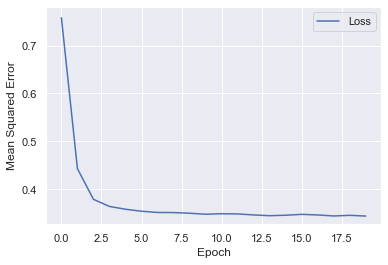


Evaluating the Deep NN Model against the test set:

3000/3000 [==============================] - 0s 54us/sample - loss: 0.4167 - mean_squared_error: 0.3775


[0.4167468150456746, 0.37746233]

In [17]:
# 1. Layer Units: 10, 2. Layers Units: 6
model = evaluate_w_hidden_layers(df = normalized_train_df, 
                                 label_name = "median_house_value", 
                                 feature_layer = my_feature_layer, 
                                 learning_rate=.01, 
                                 epochs=20, batch_size=1000)

# Split data into feature and target/label
test_features = {name:np.array(value) for name, value in normalized_test_df.items()}
test_target = np.array(test_features.pop("median_house_value")) # label isolation

print("\nEvaluating the Deep NN Model against the test set:\n")
model.evaluate(x=test_features, y=test_target, batch_size = 1000)

***
* Setting the topography as follows produced reasonably good results.
 - 15 nodes in the first layer
 - 7 nodes in the second layer

#### **Regularize the Deep NN**
The loss of the test set is much higher than the loss of the train set. In other wordsi the deep nn is overfitting the train set. To reduce overfitting, we'll regularize the model by considering following options:
- L1 Regularization
- L2 Regularization
- Dropout Regularization

Train on 17000 samples
Epoch 1/20
17000/17000 [==============================] - 1s 30us/sample - loss: 1.0017 - mean_squared_error: 0.7540
Epoch 2/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.5654 - mean_squared_error: 0.4485
Epoch 3/20
17000/17000 [==============================] - 0s 3us/sample - loss: 0.4682 - mean_squared_error: 0.3761
Epoch 4/20
17000/17000 [==============================] - 0s 3us/sample - loss: 0.4379 - mean_squared_error: 0.3624
Epoch 5/20
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4210 - mean_squared_error: 0.3567
Epoch 6/20
17000/17000 [==============================] - 0s 3us/sample - loss: 0.4123 - mean_squared_error: 0.3548
Epoch 7/20
17000/17000 [==============================] - 0s 3us/sample - loss: 0.4050 - mean_squared_error: 0.3523
Epoch 8/20
17000/17000 [==============================] - 0s 3us/sample - loss: 0.4002 - mean_squared_error: 0.3507
Epoch 9/20
17000/17000 [========================

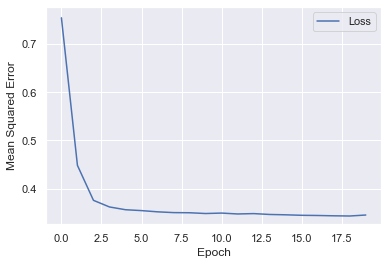


Evaluating the Deep NN Model against the test set:

3000/3000 [==============================] - 0s 55us/sample - loss: 0.4178 - mean_squared_error: 0.3833


[0.4178202748298645, 0.3832802]

In [18]:
# l2 - 0.03
model = evaluate_w_hidden_layers(df = normalized_train_df, 
                                 label_name = "median_house_value", 
                                 feature_layer = my_feature_layer, 
                                 learning_rate=.01, 
                                 epochs=20, batch_size=1000)

# Split data into feature and target/label
test_features = {name:np.array(value) for name, value in normalized_test_df.items()}
test_target = np.array(test_features.pop("median_house_value")) # label isolation

print("\nEvaluating the Deep NN Model against the test set:\n")
model.evaluate(x=test_features, y=test_target, batch_size = 1000)

Train on 17000 samples
Epoch 1/120
17000/17000 [==============================] - 1s 30us/sample - loss: 0.9948 - mean_squared_error: 0.7138
Epoch 2/120
17000/17000 [==============================] - 0s 2us/sample - loss: 0.5655 - mean_squared_error: 0.4265
Epoch 3/120
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4777 - mean_squared_error: 0.3754
Epoch 4/120
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4458 - mean_squared_error: 0.3599
Epoch 5/120
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4307 - mean_squared_error: 0.3569
Epoch 6/120
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4224 - mean_squared_error: 0.3547
Epoch 7/120
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4164 - mean_squared_error: 0.3527
Epoch 8/120
17000/17000 [==============================] - 0s 2us/sample - loss: 0.4116 - mean_squared_error: 0.3512
Epoch 9/120
17000/17000 [===============

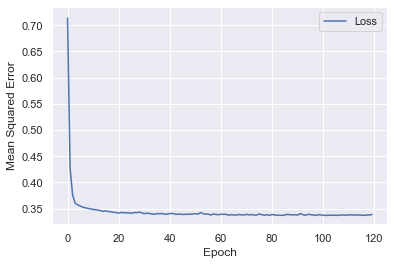


Evaluating the Deep NN Model against the test set:

3000/3000 [==============================] - 0s 52us/sample - loss: 0.3938 - mean_squared_error: 0.3701


[0.393754502137502, 0.37006593]

In [19]:
# l1 - 0.03
model = evaluate_w_hidden_layers(df = normalized_train_df, 
                                 label_name = "median_house_value", 
                                 feature_layer = my_feature_layer, 
                                 learning_rate=.007, 
                                 epochs=120, batch_size=1000)

# Split data into feature and target/label
test_features = {name:np.array(value) for name, value in normalized_test_df.items()}
test_target = np.array(test_features.pop("median_house_value")) # label isolation

print("\nEvaluating the Deep NN Model against the test set:\n")
model.evaluate(x=test_features, y=test_target, batch_size = 1000)

***